# Calculate a subject-to-subject similarity matrix for SPSQ-SF questionnaire scores

https://naturalistic-data.org/content/Intersubject_RSA.html#calculate-behavioral-similarity

Load modules

In [1]:
import os
import glob
from pathlib import Path

import numpy as np
from scipy.stats import rankdata, ttest_rel, ttest_1samp, zscore

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import pandas as pd
import seaborn as sns

import nibabel as nib
from nilearn.maskers import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold

from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

%matplotlib inline

In [2]:
data_dir = '/project/3013104.01/analysis/'
questionnaire_data = pd.read_csv(os.path.join(data_dir, 'SPSQ-24_all.csv'))
questionnaire_data.head()

,subject,as_SPS13_emotionally_touched_music_art,as_SPS29_notice_subtle_touching_tones_music,as_SPS31_very_movedy_nice_work_of_art,SPSQ_as,ep_SPS02_nervous_to_many_things_at_once,ep_SPS24_rushed_too_much_little_time,ep_SPS28_upset_when_people_ask_many_things_at_once,SPSQ_ep,sa_SPS03_see_sad_eyes_behind_smile,...,sd_SPS25_suffer_bright_light,SPSQ_sd,ss_SPS14_immediately_feel_mouth_throat_drier,ss_SPS15_hardly_visible_details_attract_attention,ss_SPS21_quickly_aware_changes_body,ss_SPS23_notice_faints_smells,SPSQ_ss,SPSQ_sum,SPSQ_pos,SPSQ_neg
0,subject-0001,1,1,1,3,1,1,4,6,1,...,1,7,7,6,4,7,24,79,66,13
1,subject-0002,2,2,1,5,1,2,4,7,4,...,4,15,4,4,4,5,17,96,74,22
2,subject-0003,6,6,6,18,1,3,4,8,1,...,4,20,4,6,6,6,22,125,97,28
3,subject-0004,4,4,4,12,4,4,4,12,4,...,3,13,4,3,4,4,15,103,78,25
4,subject-0005,3,5,2,10,3,6,4,13,6,...,5,21,6,6,5,3,20,123,89,34


Check distributions of each variable of interest. If they are not normally distributed, then convert to ranks. If they are normally distributed, then do not convert to ranks.

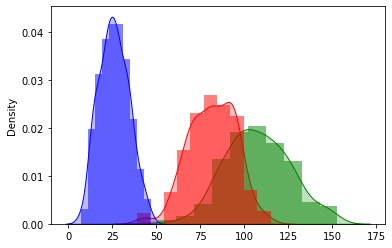

In [3]:
# Separate DataFrames for each variable
SPSQ_sum_data = questionnaire_data['SPSQ_sum']
SPSQ_pos_data = questionnaire_data['SPSQ_pos']
SPSQ_neg_data = questionnaire_data['SPSQ_neg']

# Convert the pandas Series to numpy arrays
SPSQ_sum_data = SPSQ_sum_data.values
SPSQ_pos_data = SPSQ_pos_data.values
SPSQ_neg_data = SPSQ_neg_data.values

# Plot the histograms using numpy.histogram
plt.figure()
plt.hist(SPSQ_sum_data, color='green', bins=10, alpha=0.5, density=True)
plt.hist(SPSQ_pos_data, color='red', bins=10, alpha=0.5, density=True)
plt.hist(SPSQ_neg_data, color='blue', bins=10, alpha=0.5, density=True)

# Plot the KDEs using seaborn kdeplot
sns.kdeplot(SPSQ_sum_data, color='green', fill=True)
sns.kdeplot(SPSQ_pos_data, color='red', fill=True)
sns.kdeplot(SPSQ_neg_data, color='blue', fill=True)

plt.show()

This data are normally distributed, so do not convert to ranks. Instead, raw scores can be converted to z-scores.

In [4]:
# Convert DataFrame to z-scores
questionnaire_data_z = questionnaire_data.copy()  # Create a copy of the original DataFrame

# Iterate over columns (except the first one)
for column in questionnaire_data_z.columns[1:]:
    questionnaire_data_z[column] = zscore(questionnaire_data_z[column])

questionnaire_data_z.head()

,subject,as_SPS13_emotionally_touched_music_art,as_SPS29_notice_subtle_touching_tones_music,as_SPS31_very_movedy_nice_work_of_art,SPSQ_as,ep_SPS02_nervous_to_many_things_at_once,ep_SPS24_rushed_too_much_little_time,ep_SPS28_upset_when_people_ask_many_things_at_once,SPSQ_ep,sa_SPS03_see_sad_eyes_behind_smile,...,sd_SPS25_suffer_bright_light,SPSQ_sd,ss_SPS14_immediately_feel_mouth_throat_drier,ss_SPS15_hardly_visible_details_attract_attention,ss_SPS21_quickly_aware_changes_body,ss_SPS23_notice_faints_smells,SPSQ_ss,SPSQ_sum,SPSQ_pos,SPSQ_neg
0,subject-0001,-2.550709,-2.087624,-1.483096,-2.376191,-1.566384,-2.041490,-0.080699,-1.433434,-1.760944,...,-1.278939,-1.241399,1.634671,1.281220,-0.208541,1.793478,1.641266,-1.543056,-1.165158,-1.536270
1,subject-0002,-1.886635,-1.466276,-1.483096,-1.890383,-1.566384,-1.419941,-0.080699,-1.180413,0.079576,...,0.419208,0.152350,-0.358627,-0.024586,-0.208541,0.611019,0.034573,-0.621893,-0.570925,-0.455303
2,subject-0003,0.769658,1.019114,1.389351,1.267369,-1.566384,-0.798392,-0.080699,-0.927392,-1.760944,...,0.419208,1.023444,-0.358627,1.281220,1.156973,1.202249,1.182211,0.949503,1.137498,0.265342
3,subject-0004,-0.558488,-0.223581,0.240372,-0.190055,0.517285,-0.176842,-0.080699,0.084693,0.079576,...,-0.146841,-0.196087,-0.358627,-0.677489,-0.208541,0.019790,-0.424482,-0.242590,-0.273808,-0.094980
4,subject-0005,-1.222562,0.397766,-0.908607,-0.675863,-0.177272,1.066256,-0.080699,0.337715,1.306589,...,0.985257,1.197662,0.970238,1.281220,0.474216,-0.571439,0.723156,0.841131,0.543264,0.985987


## Calculate questionnaire response similarity

### Nearest neighbors

In [2]:
# Define some helper functions
def sort_square_mtx(mtx, vct):
    """
    Sorts rows/columns of a matrix according to a separate vector.
    """
    
    inds = vct.argsort()
    mtx_sorted = mtx.copy()
    mtx_sorted = mtx_sorted[inds, :]
    mtx_sorted = mtx_sorted[:, inds]
    
    return mtx_sorted

def scale_mtx(mtx):
    """
    Scales a matrix to have values between 0 and 1.
    """
    return (mtx-np.min(mtx))/(np.max(mtx)-np.min(mtx))

Extract vector of scores for variables of interest: SPSQ total, SPSQ positive dimension, and SPSQ negative dimension

In [27]:
behav = questionnaire_data['SPSQ_neg'].values.flatten()
print(behav)

[-1.53626974 -0.45530271  0.26534198 -0.09498037  0.98598667  0.74577177
 -1.4161623  -1.65637719 -0.09498037  1.22620156  0.62566432  0.50555687
  0.38544943  0.98598667 -1.53626974  0.26534198  0.74577177 -0.81562506
  0.74577177 -1.05583995  0.50555687  0.02512708  0.26534198  1.94684625
 -0.45530271  2.18706115 -1.65637719 -2.25691443  2.3071686  -1.53626974
  0.98598667  0.50555687  0.02512708  0.98598667  0.98598667  0.26534198
 -1.05583995  0.50555687 -0.9357325   1.94684625  0.02512708 -1.65637719
  0.86587922  0.26534198  0.50555687 -0.45530271  0.74577177 -0.9357325
 -0.57541016 -0.21508782 -0.69551761  1.22620156 -0.81562506 -0.45530271
 -1.77648464 -0.33519526 -1.53626974  1.8267388  -1.4161623  -0.9357325
 -1.05583995 -0.69551761  0.14523453  0.26534198 -0.9357325   1.46641646
 -0.09498037  0.74577177  0.86587922 -0.57541016  0.86587922  0.62566432
 -1.29605485 -1.1759474   2.0669537  -0.45530271 -0.45530271 -1.53626974
 -0.09498037 -0.45530271 -1.05583995 -0.09498037 -0.3

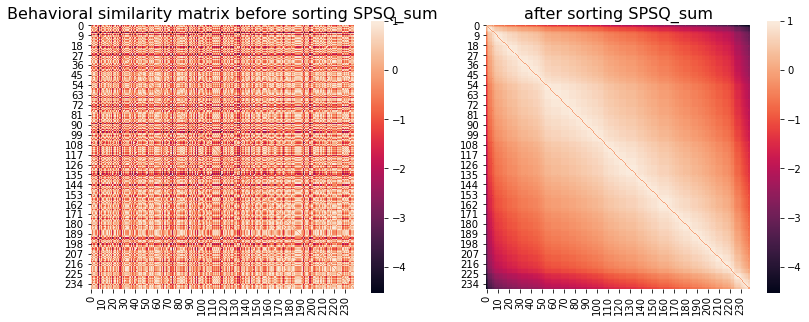

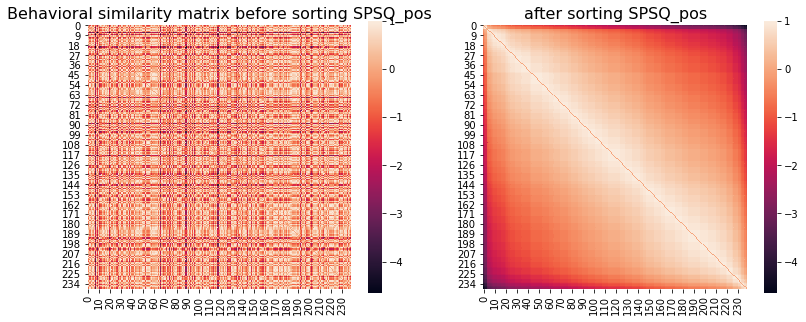

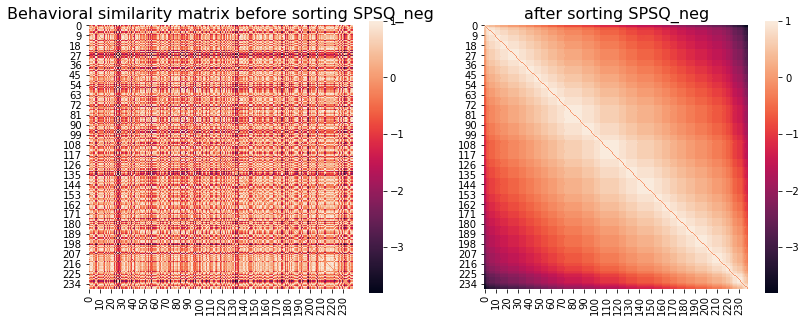

In [40]:
# Define the variables
columns = ['SPSQ_sum', 'SPSQ_pos', 'SPSQ_neg']

# Iterate over each column
for x in columns:
    behav = behav_data_z[x].values.flatten()
    behav_sim_nn = Adjacency(pairwise_distances(np.reshape(behav, (-1, 1)), metric='euclidean'), matrix_type='distance')
    behav_sim_nn = behav_sim_nn.distance_to_similarity()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    behav_sim_nn.plot(axes=ax1)
    ax1.set_title(f"Behavioral similarity matrix before sorting {x}", fontsize=16)

    sns.heatmap(sort_square_mtx(behav_sim_nn.squareform(), behav), ax=ax2, square=True)
    ax2.set_title(f"after sorting {x}", fontsize=16)

### Anna Karenina

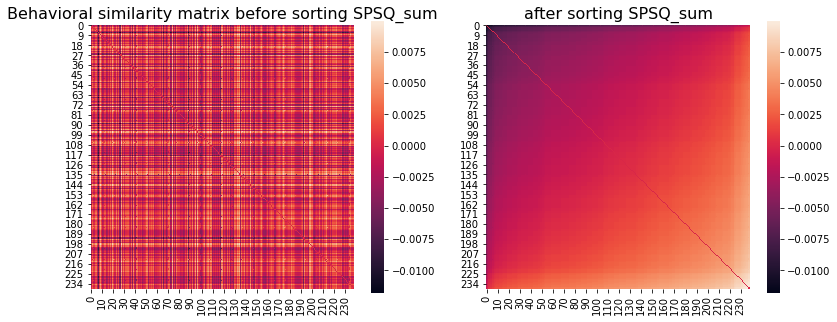

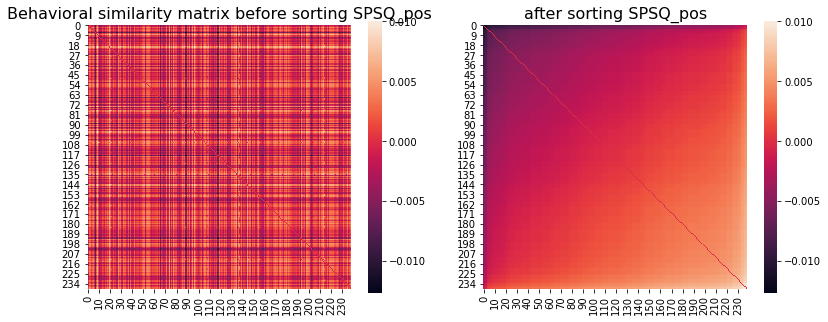

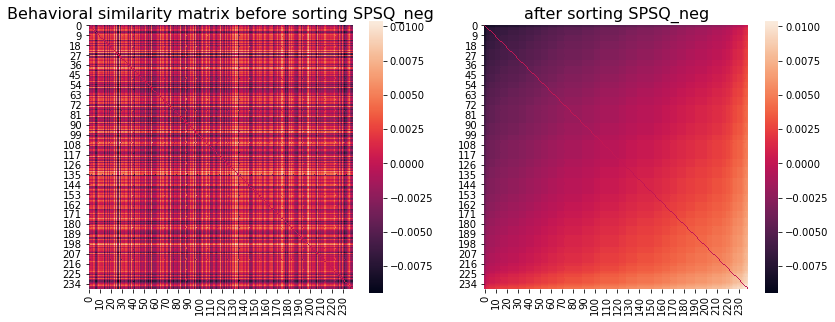

In [41]:
columns = ['SPSQ_sum', 'SPSQ_pos', 'SPSQ_neg']
for x in columns:
    behav = behav_data_z[x].values.flatten()
    n_subs = 239
    behav_sim_annak = np.zeros((n_subs, n_subs))

    for i in range(n_subs):
            for j in range(n_subs):
                if i < j:
                    sim_ij = np.mean([behav[i], behav[j]])/n_subs
                    behav_sim_annak[i,j] = sim_ij
                    behav_sim_annak[j,i] = sim_ij
                elif i==j:
                    behav_sim_annak[i,j] = 1

    behav_sim_annak = Adjacency(behav_sim_annak, matrix_type='similarity')

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
    behav_sim_annak.plot(axes=ax1)
    ax1.set_title(f"Behavioral similarity matrix before sorting {x}", fontsize=16)

    sns.heatmap(sort_square_mtx(behav_sim_annak.squareform(), behav), ax = ax2, square=True)
    ax2.set_title(f"after sorting {x}", fontsize=16)

### Intraclass correlation

In [6]:
os.chdir('/project/3013104.01/')
os.getcwd()

'/project/3013104.01'

In [7]:
# Use z-scored questionnaire data
questionnaire_data_z.head()

,subject,as_SPS13_emotionally_touched_music_art,as_SPS29_notice_subtle_touching_tones_music,as_SPS31_very_movedy_nice_work_of_art,SPSQ_as,ep_SPS02_nervous_to_many_things_at_once,ep_SPS24_rushed_too_much_little_time,ep_SPS28_upset_when_people_ask_many_things_at_once,SPSQ_ep,sa_SPS03_see_sad_eyes_behind_smile,...,sd_SPS25_suffer_bright_light,SPSQ_sd,ss_SPS14_immediately_feel_mouth_throat_drier,ss_SPS15_hardly_visible_details_attract_attention,ss_SPS21_quickly_aware_changes_body,ss_SPS23_notice_faints_smells,SPSQ_ss,SPSQ_sum,SPSQ_pos,SPSQ_neg
0,subject-0001,-2.550709,-2.087624,-1.483096,-2.376191,-1.566384,-2.041490,-0.080699,-1.433434,-1.760944,...,-1.278939,-1.241399,1.634671,1.281220,-0.208541,1.793478,1.641266,-1.543056,-1.165158,-1.536270
1,subject-0002,-1.886635,-1.466276,-1.483096,-1.890383,-1.566384,-1.419941,-0.080699,-1.180413,0.079576,...,0.419208,0.152350,-0.358627,-0.024586,-0.208541,0.611019,0.034573,-0.621893,-0.570925,-0.455303
2,subject-0003,0.769658,1.019114,1.389351,1.267369,-1.566384,-0.798392,-0.080699,-0.927392,-1.760944,...,0.419208,1.023444,-0.358627,1.281220,1.156973,1.202249,1.182211,0.949503,1.137498,0.265342
3,subject-0004,-0.558488,-0.223581,0.240372,-0.190055,0.517285,-0.176842,-0.080699,0.084693,0.079576,...,-0.146841,-0.196087,-0.358627,-0.677489,-0.208541,0.019790,-0.424482,-0.242590,-0.273808,-0.094980
4,subject-0005,-1.222562,0.397766,-0.908607,-0.675863,-0.177272,1.066256,-0.080699,0.337715,1.306589,...,0.985257,1.197662,0.970238,1.281220,0.474216,-0.571439,0.723156,0.841131,0.543264,0.985987


In [12]:
# Get column names 
print(questionnaire_data_z.columns)

Index(['subject', 'as_SPS13_emotionally_touched_music_art',
       'as_SPS29_notice_subtle_touching_tones_music',
       'as_SPS31_very_movedy_nice_work_of_art', 'SPSQ_as',
       'ep_SPS02_nervous_to_many_things_at_once',
       'ep_SPS24_rushed_too_much_little_time',
       'ep_SPS28_upset_when_people_ask_many_things_at_once', 'SPSQ_ep',
       'sa_SPS03_see_sad_eyes_behind_smile',
       'sa_SPS04_strikes_tone_voice_not_matching_words',
       'sa_SPS09_looking_eyes_telling_truth',
       'sa_SPS12_strikes_when_acting_not_afraid',
       'sa_SPS22_tell_smile_masking_feelings', 'SPSQ_sa',
       'sc_SPS05_hard_enjoy_little_things_reversed',
       'sc_SPS10_feel_good_with_people_I_love',
       'sc_SPS17_enjoy_humour_situations', 'sc_SPS19_enjoy_relaxing_activity',
       'sc_SPS30_watching_nice_movie_feels_good', 'SPSQ_sc',
       'sd_SPS06_flashing_lights_bother',
       'sd_SPS16_easily_disturbed_light_odors',
       'sd_SPS20_loud_noises_irritating', 'sd_SPS25_suffer_bright_light

In [8]:
# Check for missing values in each column (False = no missing values)
missing_values_in_columns = questionnaire_data_z.isnull().any()
print(missing_values_in_columns)

subject                                               False
as_SPS13_emotionally_touched_music_art                False
as_SPS29_notice_subtle_touching_tones_music           False
as_SPS31_very_movedy_nice_work_of_art                 False
SPSQ_as                                               False
ep_SPS02_nervous_to_many_things_at_once               False
ep_SPS24_rushed_too_much_little_time                  False
ep_SPS28_upset_when_people_ask_many_things_at_once    False
SPSQ_ep                                               False
sa_SPS03_see_sad_eyes_behind_smile                    False
sa_SPS04_strikes_tone_voice_not_matching_words        False
sa_SPS09_looking_eyes_telling_truth                   False
sa_SPS12_strikes_when_acting_not_afraid               False
sa_SPS22_tell_smile_masking_feelings                  False
SPSQ_sa                                               False
sc_SPS05_hard_enjoy_little_things_reversed            False
sc_SPS10_feel_good_with_people_I_love   

Specify which questionnaire items to use in ICC calculations

In [23]:
sum_score = ['as_SPS13_emotionally_touched_music_art', 'as_SPS29_notice_subtle_touching_tones_music',
                       'as_SPS31_very_movedy_nice_work_of_art', 'ep_SPS02_nervous_to_many_things_at_once',
                       'ep_SPS24_rushed_too_much_little_time', 'ep_SPS28_upset_when_people_ask_many_things_at_once',
                       'sa_SPS03_see_sad_eyes_behind_smile', 'sa_SPS04_strikes_tone_voice_not_matching_words',
                       'sa_SPS09_looking_eyes_telling_truth', 'sa_SPS12_strikes_when_acting_not_afraid',
                       'sa_SPS22_tell_smile_masking_feelings', 'sc_SPS05_hard_enjoy_little_things_reversed',
                       'sc_SPS10_feel_good_with_people_I_love', 'sc_SPS17_enjoy_humour_situations',
                       'sc_SPS19_enjoy_relaxing_activity', 'sc_SPS30_watching_nice_movie_feels_good',
                       'sd_SPS06_flashing_lights_bother', 'sd_SPS16_easily_disturbed_light_odors',
                       'sd_SPS20_loud_noises_irritating', 'sd_SPS25_suffer_bright_light',
                       'ss_SPS14_immediately_feel_mouth_throat_drier',
                       'ss_SPS15_hardly_visible_details_attract_attention',
                       'ss_SPS21_quickly_aware_changes_body', 'ss_SPS23_notice_faints_smells']

positive_score = ['as_SPS13_emotionally_touched_music_art', 'as_SPS29_notice_subtle_touching_tones_music',
                       'as_SPS31_very_movedy_nice_work_of_art',
                       'sa_SPS03_see_sad_eyes_behind_smile', 'sa_SPS04_strikes_tone_voice_not_matching_words',
                       'sa_SPS09_looking_eyes_telling_truth', 'sa_SPS12_strikes_when_acting_not_afraid',
                       'sa_SPS22_tell_smile_masking_feelings', 'sc_SPS05_hard_enjoy_little_things_reversed',
                       'sc_SPS10_feel_good_with_people_I_love', 'sc_SPS17_enjoy_humour_situations',
                       'sc_SPS19_enjoy_relaxing_activity', 'sc_SPS30_watching_nice_movie_feels_good',
                       'ss_SPS14_immediately_feel_mouth_throat_drier',
                       'ss_SPS15_hardly_visible_details_attract_attention',
                       'ss_SPS21_quickly_aware_changes_body', 'ss_SPS23_notice_faints_smells']

negative_score = ['ep_SPS02_nervous_to_many_things_at_once',
                       'ep_SPS24_rushed_too_much_little_time', 'ep_SPS28_upset_when_people_ask_many_things_at_once',
                       'sd_SPS06_flashing_lights_bother', 'sd_SPS16_easily_disturbed_light_odors',
                       'sd_SPS20_loud_noises_irritating', 'sd_SPS25_suffer_bright_light']

Calculate ICC manually using two-way random effects model for absolute agreement and calculate the ICC for each pair of subjects across multiple questionnaire items

In [25]:
subject_names = questionnaire_data_z['subject']

# Specific questionnaire items for ICC calculations
questionnaire_items = negative_score

# Create an empty DataFrame to store the ICC values
icc_matrix = pd.DataFrame(index=subject_names, columns=subject_names)
# Function to calculate the Intraclass Correlation Coefficient 
def calculate_icc(data1, data2):
    assert len(data1) == len(data2), "Data arrays must have the same length."
    n = len(data1)
    numerator = np.sum((data1 - data1.mean()) * (data2 - data2.mean()))
    denominator = np.sqrt(np.sum((data1 - data1.mean())**2) * np.sum((data2 - data2.mean())**2))
    return numerator / denominator
# Iterate through each pair of subjects
for i, subject1 in enumerate(subject_names):
    for j, subject2 in enumerate(subject_names):
        if i == j:
            # Skip comparing the subject with themselves, ICC will be 1.0 in this case
            icc_matrix.loc[subject1, subject2] = 1.0
        else:
            # Get the data for the two subjects and the questionnaire items
            data_subject1 = questionnaire_data_z[questionnaire_data_z['subject'] == subject1][questionnaire_items].values.flatten()
            data_subject2 = questionnaire_data_z[questionnaire_data_z['subject'] == subject2][questionnaire_items].values.flatten()
            # Calculate the ICC between the two subjects
            icc_value = calculate_icc(data_subject1, data_subject2)
            # Store the ICC value in the matrix
            icc_matrix.loc[subject1, subject2] = icc_value
# Convert the ICC values from strings to floats
icc_matrix = icc_matrix.astype(float)
# Save the ICC matrix to a CSV file
icc_matrix.to_csv('analysis/icc_negative.csv', index=True)
# Print the ICC matrix
print(icc_matrix)

subject       subject-0001  subject-0002  subject-0003  subject-0004  \
subject                                                                
subject-0001      1.000000      0.504615      0.409106     -0.229994   
subject-0002      0.504615      1.000000      0.747545     -0.538861   
subject-0003      0.409106      0.747545      1.000000     -0.765860   
subject-0004     -0.229994     -0.538861     -0.765860      1.000000   
subject-0005     -0.257939      0.380234      0.582836     -0.732225   
...                    ...           ...           ...           ...   
subject-0235      0.391365      0.639870      0.719725     -0.419735   
subject-0236      0.361289      0.879722      0.470816     -0.471394   
subject-0237     -0.619583     -0.656524     -0.756111      0.840011   
subject-0238     -0.091115      0.740090      0.733015     -0.454951   
subject-0239     -0.417046     -0.658033     -0.806726      0.374002   

subject       subject-0005  subject-0006  subject-0007  subject

Plot 

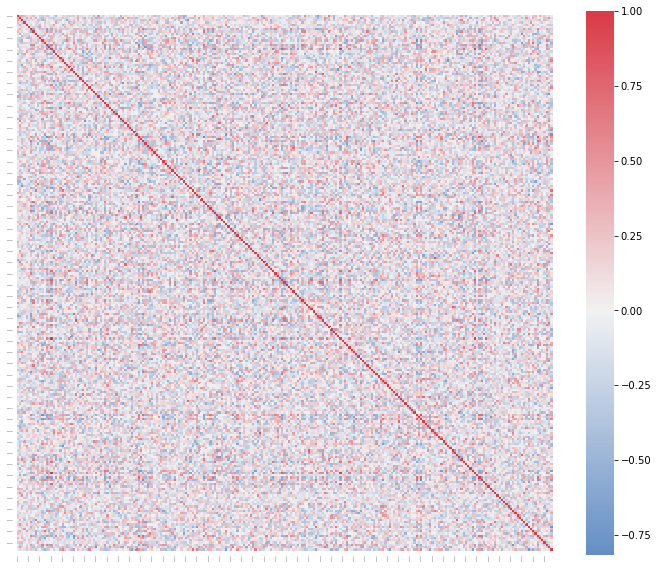

In [22]:
icc_matrix = pd.read_csv('analysis/icc_matrix.csv', index_col=0)

# Create a large heatmap and set color scale for colorblindness
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(icc_matrix, annot=False, cmap=cmap, center=0, cbar=True, square=True, linewidths=0)

# Remove axis labels and tick marks
plt.xlabel('')
plt.ylabel('')
plt.tick_params(axis='both', which='both', length=0, labelsize=0)

# Hide the color bar label (correlation values)
cbar = plt.gca().collections[0].colorbar
cbar.set_label('')

plt.show()